In [2]:
#setup
from Building import Builder
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import pyplot
import MDAnalysis as mda
import tqdm.notebook as tqdm
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import numpy as np

plt.rcParams.update({
"font.size": 16,
"text.usetex": False,
#"font.family": "Times New Roman",
"mathtext.fontset": "stixsans"
})

root="/scratch/rasera/CRESCO/FE"

In [3]:
def write_gromacs_top(system_name, molecules, output_file, includes):
    with open(output_file, 'w') as f:
        for include in includes:
            f.write(f'#include "{include}"\n')
        
        f.write(f'[ system ]\n{system_name}\n\n')
        
        f.write('[ molecules ]\n')
        for molecule, count in molecules.items():
            f.write(f'  {molecule}     {count}\n')

In [ ]:
u = mda.Universe(root+"/start_files/Fullerene.gro")
atom_group = u.select_atoms("all")
centroid = atom_group.center_of_geometry()
distances = np.linalg.norm(atom_group.positions - centroid, axis=1)
radius = np.max(distances)

print(f"Radius of the smallest enclosing sphere: {radius*.1:.3f} nm")

plt.scatter(atom_group.positions[:,0], atom_group.positions[:,1])
plt.scatter(centroid[0], centroid[1])
circle = plt.Circle((centroid[0], centroid[1]), radius, color='orange', alpha=0.3, label=f'Enclosing Circle (r={radius:.2f} Å)')
plt.gca().add_patch(circle)

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

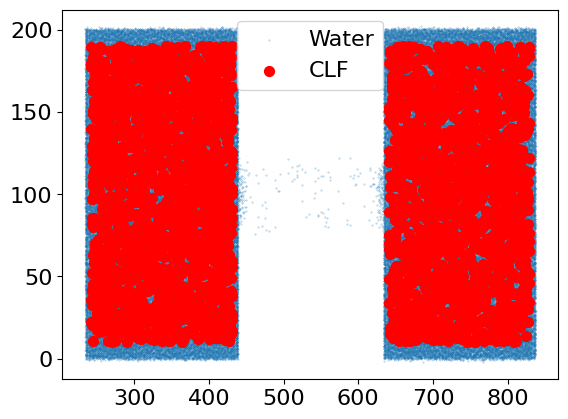

In [6]:
def insert_gas_with_radius(file, insert_file, outfile, R, resname, N):
    u = mda.Universe(file)
    bulk = u.select_atoms("resname BULK")
    pis = u.select_atoms("resname PIS")
    pis1 = u.select_atoms("resname PIS1")

    # Define the bounds for molecule placement
    x_min, x_max = pis.positions[:,0].min(), pis.positions[:,0].max()
    y_min, y_max = pis.positions[:,1].min(), pis.positions[:,1].max()
    x_min, x_max = x_min + 2 * R, x_max - 2 * R
    y_min, y_max = y_min + 2 * R, y_max - 2 * R


    N = N // 2  # Half molecules per region

    inserted_centroids = [] 
    atoms_to_replace = []
    atoms_to_insert = []

    fig, ax = plt.subplots()

    for mins in [(pis.positions[:,2].max(), bulk.positions[:,2].min()), 
                 (bulk.positions[:,2].max(), pis1.positions[:,2].min())]:
        z_min, z_max = mins
        z_min, z_max = z_min + 2 * R, z_max - 2 * R
        water_atoms = u.select_atoms(f"(resname W or resname SW or resname TW) and prop z >= {z_min} and prop z <= {z_max} and prop x >= {x_min} and prop x <= {x_max} and prop y >= {y_min} and prop y <= {y_max}")

        for _ in tqdm.tqdm(range(N)):
            max_attempts = 1000
            for _ in range(max_attempts):
                centroid = np.array([
                    np.random.uniform(x_min, x_max),
                    np.random.uniform(y_min, y_max),
                    np.random.uniform(z_min, z_max)
                ])
                insert_u = mda.Universe(insert_file)

                if all(np.linalg.norm(centroid - c) >= 2 * R for c in inserted_centroids):
                    inserted_centroids.append(centroid)
                    
                    distances = np.linalg.norm(water_atoms.positions - centroid, axis=1)
                    atoms_to_replace.append(water_atoms[distances <= R])

                    insert_centroid = insert_u.atoms.center_of_geometry()
                    shift = centroid - insert_centroid
                    insert_u.atoms.translate(shift)  # Apply translation correctly

                    atoms_to_insert.append(insert_u.atoms)
                   
                    #print(f"Inserted {resname} at {centroid}, replaced {len(atoms_to_replace)} water molecules.")
                    break
            else:
                print(f"Failed to place molecule {len(inserted_centroids) + 1} without overlap after {max_attempts} attempts.")

    remaining_atoms = u.atoms
    for group in atoms_to_replace:
        remaining_atoms = remaining_atoms.difference(group)

    all_atoms = [remaining_atoms]
    for group in atoms_to_insert:
        all_atoms.append(group)

    new_universe = mda.Merge(*all_atoms)
    new_universe.dimensions = u.dimensions
    new_universe.atoms.write(outfile)

    water = new_universe.select_atoms("resname W or resname SW or resname TW")
    gas = new_universe.select_atoms(f"resname {resname}")

    ax.scatter(water.positions[:, 2], water.positions[:, 0], s=0.1, alpha=0.5, label="Water")
    ax.scatter(gas.positions[:, 2], gas.positions[:, 0], color='red', s=50, label=f"{resname}")
    ax.legend()
    plt.show()

root = '/scratch/rasera/CRESCO/FE'
mol = "Chloroform"
resname = "CLF"
atomname = "CX"
ngas = 3000
outfile = f"{root}/start_files/eqruns/{mol}/{ngas}/FE_{resname}_{ngas}.gro"
insert_file = f"{root}/start_files/{mol}.gro"
file = f"{root}/start_files/FE.gro"
R = 5 # Å

insert_gas_with_radius(file, insert_file, outfile, R, resname, N=ngas)


In [7]:
root = '/scratch/rasera/CRESCO/FE'
mol = "Nitrogen"
resname = "NI2"
atomname = "TN6"
ngas = 100

u = mda.Universe(root+f"/start_files/eqruns/{mol}/{ngas}/FE_{resname}_{ngas}.gro")
SIL = u.select_atoms("name N1L1").n_atoms
LAY = u.select_atoms("name N1L").n_atoms
PIS = u.select_atoms("resname PIS").n_atoms
PIS1 = u.select_atoms("resname PIS1").n_atoms
BULK = u.select_atoms("name N1B").n_atoms
GASMOL = u.select_atoms(f"resname {resname}").n_atoms
W = u.select_atoms("resname W").n_atoms
SW = u.select_atoms("resname SW").n_atoms
TW = u.select_atoms("resname TW").n_atoms

print(SIL,LAY,PIS,PIS1,BULK,GASMOL)

molecules = {
    "PIS": PIS,
    "SIL": SIL,
    "LAY": LAY,
    "BULK": BULK,
    "PIS1": PIS,
    "TW": TW,
    "SW": SW,
    "W": W,
    f"{resname}": GASMOL
}


includes = [
    "martini_v3.0.0_N1Lay.itp",
    "martini_v3.0.0_solvents_v1.itp",
    "lay1-sil.itp",
    "surf.itp",
]

write_gromacs_top(system_name="System",
                  molecules=molecules,
                  output_file=root+f"/start_files/eqruns/{mol}/{ngas}/FE_{resname}_{ngas}.top",
                  includes=includes)

411 1389 10032 10032 70695 100


In [ ]:
import numpy as np
import MDAnalysis as mda
import matplotlib.pyplot as plt

def insert_gas_with_radius(file, insert_file, outfile, R, resname, N):
    u = mda.Universe(file)
    bulk = u.select_atoms("resname BULK")
    pis = u.select_atoms("resname PIS")
    pis1 = u.select_atoms("resname PIS1")

    x_min, x_max = pis.positions[:,0].min(), pis.positions[:,0].max()
    y_min, y_max = pis.positions[:,1].min(), pis.positions[:,1].max()
    x_min, x_max = x_min + 2 * R, x_max - 2 * R
    y_min, y_max = y_min + 2 * R, y_max - 2 * R

    N = N // 2

    inserted_centroids = []
    merged_atoms_list = [u.atoms]  # Start with original universe atoms

    fig, ax = plt.subplots()

    for mins in [(pis.positions[:,2].max(), bulk.positions[:,2].min()), 
                 (bulk.positions[:,2].max(), pis1.positions[:,2].min())]:
        z_min, z_max = mins
        z_min, z_max = z_min + 2 * R, z_max - 2 * R
        water_atoms = u.select_atoms(f"(resname W or resname SW or resname TW) and prop z >= {z_min} and prop z <= {z_max} and prop x >= {x_min} and prop x <= {x_max} and prop y >= {y_min} and prop y <= {y_max}")

        for _ in tqdm.tqdm(range(N)):
            max_attempts = 100000
            insert_u = mda.Universe(insert_file)
            insert_centroid = insert_u.atoms.center_of_geometry()

            for _ in range(max_attempts):
                centroid = np.array([
                    np.random.uniform(x_min, x_max),
                    np.random.uniform(y_min, y_max),
                    np.random.uniform(z_min, z_max)
                ])
                
                # Check distance to already inserted centroids
                if all(np.linalg.norm(centroid - c) >= 2 * R for c in inserted_centroids):
                    inserted_centroids.append(centroid)
                    
                    distances = np.linalg.norm(water_atoms.positions - centroid, axis=1)
                    atoms_to_replace = water_atoms[distances <= R]
                    remaining_atoms = u.atoms.difference(atoms_to_replace)

                    shift = centroid - insert_centroid
                    insert_u.atoms.translate(shift)

                    # Merge the inserted atoms into the list (instead of overwriting)
                    merged_atoms_list.append(insert_u.atoms)
                    #print(f"Inserted {resname} at {centroid}, replaced {len(atoms_to_replace)} water molecules.")
                    break
                
            if _ == max_attempts - 1:
                print(f"Failed to place molecule {len(inserted_centroids) + 1} without overlap after {max_attempts} attempts.")
                continue

    # Merge all the atoms into one universe
    all_atoms = mda.Merge(*merged_atoms_list)
    
    # Update dimensions and write to file
    all_atoms.dimensions = u.dimensions
    all_atoms.atoms.write(outfile)

    # Plot the insertion
    water = all_atoms.select_atoms("resname W or resname SW or resname TW")
    gas = all_atoms.select_atoms(f"resname {resname}")

    ax.scatter(water.positions[:, 2], water.positions[:, 0], s=0.1, alpha=0.5, label="Water")
    ax.scatter(gas.positions[:, 2], gas.positions[:, 0], color='red', s=5, label=f"{resname}")
    ax.legend(fontsize=8)
    ax.set_aspect('equal')
    plt.show()

file = f"{root}/start_files/FE.gro"
insert_file = f"{root}/start_files/Diethyl_ether.gro"
outfile = f"{root}/start_files/FE_ETH_5000.gro"
R = 5 # Å
resname = "ETH"

insert_gas_with_radius(file, insert_file, outfile, R, resname, N=5000)


In [ ]:
mol='Nitrogen'
aname='NI2'
kappa='0.01'
sys='C8,1.2'
ngas=1000
root='/scratch/rasera/CRESCO/FE'
start_folder=${root}/start_files/eqruns/${mol}/${ngas}

source /home/rasera/modules.sh
cp ${root}/start_files/*.itp $start_folder/
cp ${root}/start_files/run_pull.mdp $start_folder/
cp ${root}/start_files/run_mono_pull.sh $start_folder/
cp ${root}/start_files/FE.top $start_folder/

cd $start_folder
awk -v n="$ngas" '
    $1 == "W" { 
        $2 -= n 
    } 
    { print }
    END { print "'${aname}'", n }' "FE.top" > FE_with_gas.top

echo -e "r W | r SW | r TW | r '${aname}'\nname 12 WATER_GAS\nq" | gmx_mpi make_ndx -f FE_with_gas.gro -o index.ndx
gmx_mpi grompp -f run_pull.mdp -c FE_with_gas.gro -p FE_with_gas.top -o FE.tpr -maxwarn 1 -n index.ndx



In [4]:
%%bash

root='/scratch/rasera/CRESCO/FE'
kappa='0.01'
sys='C8,1.2'
ngas=10
mols=(Chloroform Ethylene Diethyl_ether Nitrogen)
start_folder=$root/start_files/eqruns/

for mol in ${mols[@]}; do
    run_folder=$root/$mol/$sys/$ngas/start_files
    cp $start_folder/$mol/FE.gro $run_folder/
    cp $start_folder/$mol/FE_with_gas.top $run_folder/FE.top
    cp $start_folder/$mol/*.itp $run_folder/
    cp $start_folder/$mol/run_pull.mdp $run_folder/
    cp $start_folder/$mol/index.ndx $run_folder/
    cp $root/start_files/run_mono.sh $run_folder/
done
